/Users/keyansaguibo/PyCharmMiscProject/.venv/quant_projects/equity_analysis.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)["Close"]
[*********************100%***********************]  2 of 2 completed


Cointegration p-value: 0.07110622021974276
Hedge ratio (KO vs PEP): 0.27155136692670356


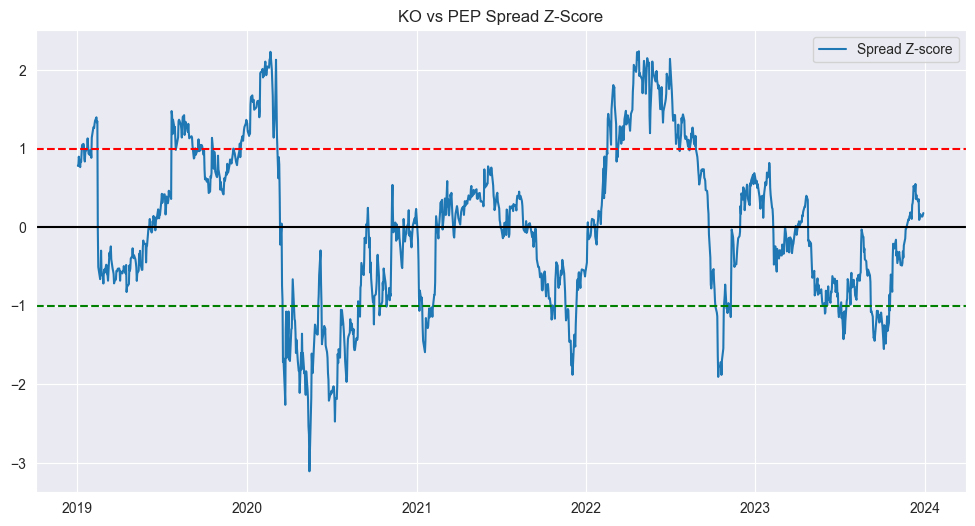

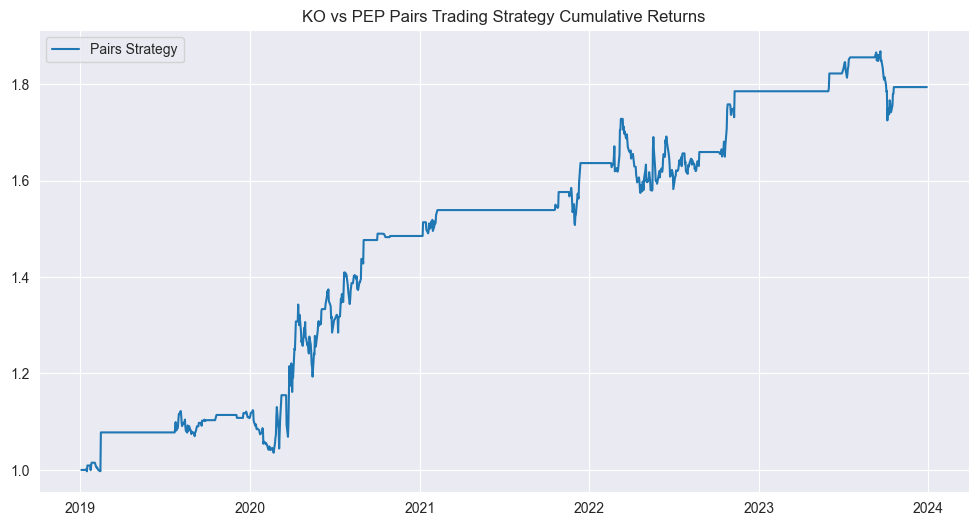

Sharpe Ratio: 0.9739933664231242


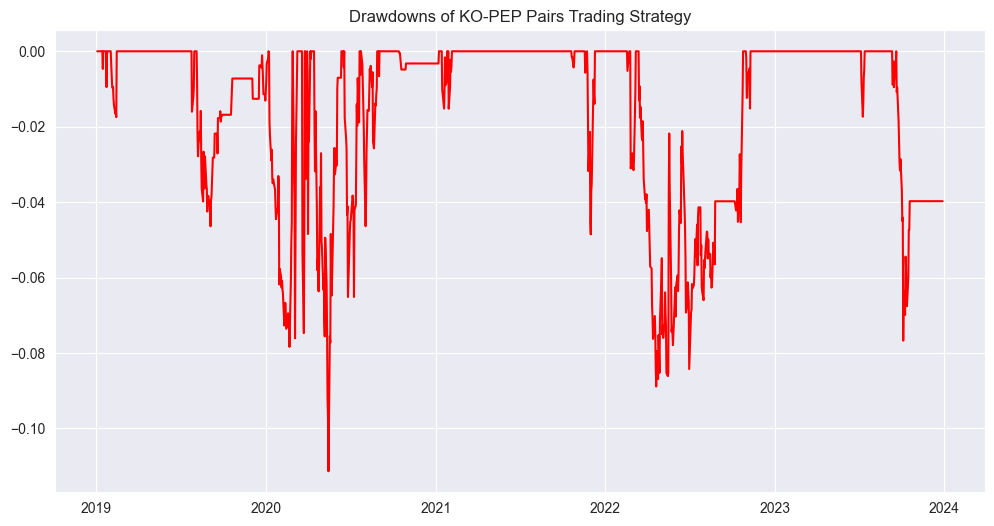

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import equity_analysis as ea  # your helper functions

# Step 1: Load data
tickers = ["KO", "PEP"]
prices = ea.get_data(tickers, start="2019-01-01", end="2024-01-01")

# Step 2: Returns
returns = ea.compute_returns(prices)

# Step 3: Cointegration test (Engle-Granger)
score, pvalue, _ = sm.tsa.coint(prices["KO"], prices["PEP"])
print("Cointegration p-value:", pvalue)

# Step 4: Hedge ratio via regression
X = sm.add_constant(prices["PEP"])
model = sm.OLS(prices["KO"], X).fit()
hedge_ratio = model.params["PEP"]
print("Hedge ratio (KO vs PEP):", hedge_ratio)

# Step 5: Spread & z-score
spread = prices["KO"] - hedge_ratio * prices["PEP"]
zscore = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(12,6))
plt.plot(zscore, label="Spread Z-score")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.axhline(0.0, color="black")
plt.title("KO vs PEP Spread Z-Score")
plt.legend()
plt.show()

# Step 6: Trading signals
longs = zscore < -1
shorts = zscore > 1
positions = np.zeros(len(zscore))
positions[longs] = 1   # long KO, short PEP
positions[shorts] = -1 # short KO, long PEP

# Step 7: Align positions with returns
positions = pd.Series(positions, index=prices.index)
positions = positions.shift(1).reindex(returns.index).fillna(0)

# Step 8: Strategy returns
strategy_returns = positions * (returns["KO"] - hedge_ratio * returns["PEP"])
cum_strategy = (1 + strategy_returns).cumprod()

plt.figure(figsize=(12,6))
plt.plot(cum_strategy, label="Pairs Strategy")
plt.title("KO vs PEP Pairs Trading Strategy Cumulative Returns")
plt.legend()
plt.show()

# Step 9: Performance metrics
sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
print("Sharpe Ratio:", sharpe)

cum_strat = ea.compute_cumulative_returns(strategy_returns)
drawdowns = ea.compute_drawdowns(cum_strat)

plt.figure(figsize=(12,6))
plt.plot(drawdowns, color="red")
plt.title("Drawdowns of KO-PEP Pairs Trading Strategy")
plt.show()

